In [1]:
from collections import defaultdict, OrderedDict
from lxml import etree
from discoursegraphs import t
from discoursegraphs.readwrite.rst.rs3 import extract_relationtypes

In [2]:
RS3_EXAMPLE_FILE = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-1818.rs3'

In [3]:
def get_rs3_data(rs3_file):
    rs3_etree = etree.parse(rs3_file)
    reltypes = extract_relationtypes(rs3_etree)
    elements = defaultdict(lambda : defaultdict(str))
    children = defaultdict(list)
    ordered_edus = []

    for elem in rs3_etree.iter('segment', 'group'):
        elem_id = elem.attrib['id']
        parent_id = elem.attrib.get('parent')
        elements[elem_id]['parent'] = parent_id
        children[parent_id].append(elem_id)
        
        relname = elem.attrib.get('relname')
        elements[elem_id]['relname'] = relname
        if relname == None:
            # nodes without a parent have no relname attribute
            elements[elem_id]['nuclearity'] = 'root'
        else:
            reltype = reltypes.get(relname, 'span')
            elements[elem_id]['reltype'] = reltype
            if reltype == 'rst':
                # this elem is the S of an N-S relation, its parent is the N
                elements[elem_id]['nuclearity'] = 'satellite'
            elif reltype == 'multinuc':
                # this elem is one of several Ns of a multinuc relation.
                # its parent is the multinuc relation node.
                elements[elem_id]['nuclearity'] = 'nucleus'
            elif reltype == 'span':
                # this elem is the N of an N-S relation, its parent is a span
                elements[elem_id]['nuclearity'] = 'nucleus'
            else:
                raise NotImplementedError("Unknown reltype: {}".format(reltypes[relname]))
        
        elem_type = elem.tag
        elements[elem_id]['element_type'] = elem_type
        
        if elem_type == 'segment':
            elements[elem_id]['text'] = elem.text
            ordered_edus.append(elem_id)
        else:  # elem_type == 'group':
            elements[elem_id]['group_type'] = elem.attrib.get('type')
    return children, elements, ordered_edus

In [4]:
def get_position(node_id, child_dict, ordered_edus, edu_set):
    if node_id in edu_set:
        return ordered_edus.index(node_id)
    else:
        return min(get_position(child_node_id, child_dict, ordered_edus, edu_set)
                   for child_node_id in child_dict[node_id])

In [5]:
# edu_set = set(ordered_edus)
# def c2t(child_dict, ordered_edus, edu_set, start_node=None):
#     if len(child_dict[start_node]) == 0:
#         return t(str(start_node))
#     else:
#         subtrees = [c2t(child_dict, ordered_edus, edu_set, start_node=c)
#                     for c in child_dict[start_node]]
#         return t(str(start_node), subtrees)

In [6]:
def dt(child_dict, elem_dict, ordered_edus, start_node=None):
    elem_id = start_node
    if elem_id not in elem_dict:
        return []
    
    elem = elem_dict[elem_id]
    elem_type = elem['element_type']
    
    if elem_type == 'segment':
        if elem['nuclearity'] == 'root':
            return t('N ({})'.format(elem_id), elem['text'])
        
        if elem['reltype'] == 'rst':
            # this elem is the S in an N-S relation
            assert elem_id not in child_dict
            return t('S ({})'.format(elem_id), elem['text'])

        elif elem['reltype'] == 'multinuc':
            # this elem is one of several Ns in a multinuc relation
            assert elem_id not in child_dict
            return t('N ({})'.format(elem_id), elem['text'])
            
        else:  # elem['reltype'] == 'span'
            # this elem is the N in an N-S relation
            nuc_tree = t('N ({})'.format(elem_id), elem['text'])
            
            assert len(child_dict[elem_id]) == 1
            satellite_id = child_dict[elem_id][0]
            satellite_elem = elem_dict[satellite_id]
            sat_subtree = dt(child_dict, elem_dict, ordered_edus, start_node=satellite_id)
            relname = satellite_elem['relname']
            
            if get_position(elem_id, child_dict, ordered_edus, edu_set) \
                < get_position(satellite_id, child_dict, ordered_edus, edu_set):
                    subtrees = [nuc_tree, sat_subtree]
            else:
                    subtrees = [sat_subtree, nuc_tree]
            return t(relname, subtrees)

    else:  # elem_type == 'group':
        if elem['reltype'] == 'rst':
            # this elem is the S in an N-S relation
            assert len(child_dict[elem_id]) == 1
            child_id = child_dict[elem_id][0]
            subtree = dt(child_dict, elem_dict, ordered_edus, start_node=child_id)
            return t('S ({})'.format(elem_id), subtree)

        elif elem['reltype'] == 'multinuc':
            # this elem is one of several Ns in a multinuc relation
            assert len(child_dict[elem_id]) == 1
            child_id = child_dict[elem_id][0]
            subtree = dt(child_dict, elem_dict, ordered_edus, start_node=child_id)
            return t('n ({})'.format(elem_id), subtree)

        else: # elem_type == 'group' and elem['reltype'] == 'span'
            # this elem is the N in an N-S relation
            if elem['group_type'] == 'multinuc':
                # this elem is also the 'root node' of a multinuc relation
                child_ids = child_dict[elem_id]
                multinuc_child_ids = [c for c in child_ids
                                      if elem_dict[c]['reltype'] == 'multinuc']
                multinuc_relname = elem_dict[multinuc_child_ids[0]]['relname']
                multinuc_subtree = t(multinuc_relname, [
                    dt(child_dict, elem_dict, ordered_edus, start_node=mc) 
                    for mc in multinuc_child_ids])
                nuc_tree = ('N ({})'.format(elem_id), multinuc_subtree)
                
                other_child_ids = [c for c in child_ids
                                   if c not in multinuc_child_ids]
                assert len(other_child_ids) == 1
                
                satellite_id = other_child_ids[0]
                satellite_elem = elem_dict[satellite_id]
                sat_subtree = dt(child_dict, elem_dict, ordered_edus, start_node=satellite_id)
                relname = satellite_elem['relname']

                # --- <start> copied from element_type: segment / reltype: span ---
                if get_position(elem_id, child_dict, ordered_edus, edu_set) \
                    < get_position(satellite_id, child_dict, ordered_edus, edu_set):
                        subtrees = [nuc_tree, sat_subtree]
                else:
                        subtrees = [sat_subtree, nuc_tree]
                return t(relname, subtrees)
                # --- <end> copied from element_type: segment / reltype: span ---

            else:  # elem['group_type'] == 'span'
                if len(child_dict[elem_id]) == 1:
                    child_id = child_dict[elem_id][0]
                    subtree = dt(child_dict, elem_dict, ordered_edus, start_node=child_id)
                    return t('N ({})'.format(elem_id), subtree)

                elif len(child_dict[elem_id]) == 2:
                    # this elem is the N of an N-S relation (child: S), but is also
                    # a span over another relation (child: N)
                    children = {}
                    for child_id in child_dict[elem_id]:
                        children[elem_dict[child_id]['nuclearity']] = child_id
                    
                    satellite_id = children['satellite']
                    satellite_elem = elem_dict[satellite_id]
                    relname = satellite_elem['relname']
                    
                    sat_subtree = dt(child_dict, elem_dict, ordered_edus,
                                     start_node=children['satellite'])
                    nuc_subtree = dt(child_dict, elem_dict, ordered_edus,
                                     start_node=children['nucleus'])
                    nuc_tree = ('N ({})'.format(elem_id), nuc_subtree)

                    # --- <start> adapted from element_type: segment / reltype: span ---
                    if get_position(children['nucleus'], child_dict, ordered_edus, edu_set) \
                        < get_position(children['satellite'], child_dict, ordered_edus, edu_set):
                            subtrees = [nuc_tree, sat_subtree]
                    else:
                            subtrees = [sat_subtree, nuc_tree]
                    return t(relname, subtrees)
                    # --- <end> adapted from element_type: segment / reltype: span ---

                else: #len(child_dict[elem_id]) == 0 or len(child_dict[elem_id]) > 2
                    raise NotImplementedError

# Testing

In [7]:
cdict, edict, ordered_edus = get_rs3_data(RS3_EXAMPLE_FILE)
edu_set = set(ordered_edus)

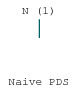

In [8]:
dt(cdict, edict, ordered_edus, start_node='1') # OK

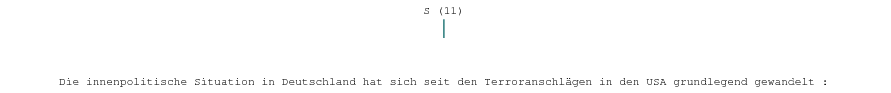

In [9]:
dt(cdict, edict, ordered_edus, start_node='11') # OK

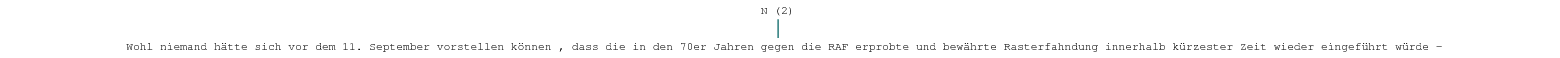

In [10]:
dt(cdict, edict, ordered_edus, start_node='2') # OK

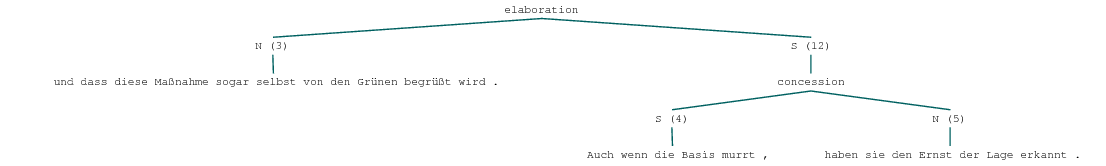

In [11]:
dt(cdict, edict, ordered_edus, start_node='3') # OK

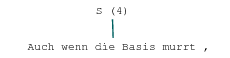

In [12]:
dt(cdict, edict, ordered_edus, start_node='4') # OK

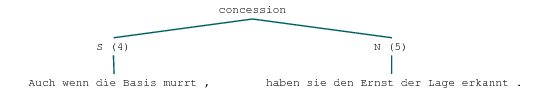

In [13]:
dt(cdict, edict, ordered_edus, start_node='5') # OK

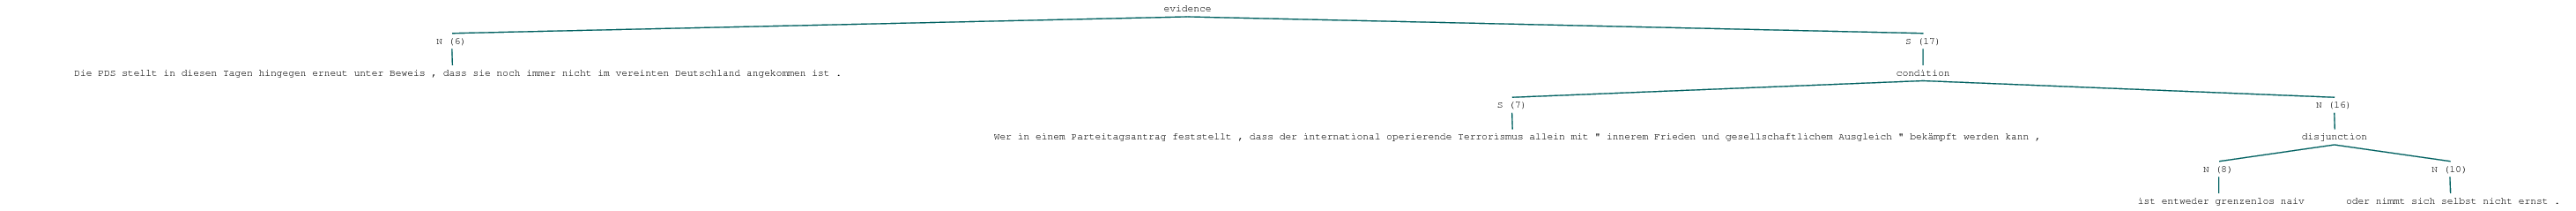

In [14]:
dt(cdict, edict, ordered_edus, start_node='6') # OK

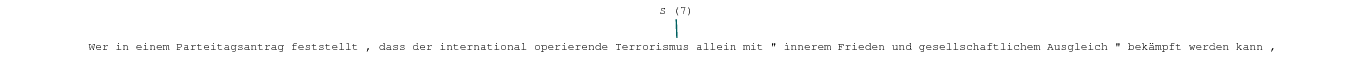

In [15]:
dt(cdict, edict, ordered_edus, start_node='7') # OK

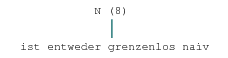

In [16]:
dt(cdict, edict, ordered_edus, start_node='8') # OK

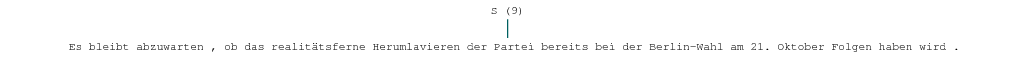

In [17]:
dt(cdict, edict, ordered_edus, start_node='9') # OK

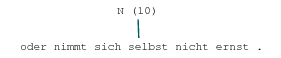

In [18]:
dt(cdict, edict, ordered_edus, start_node='10') # OK

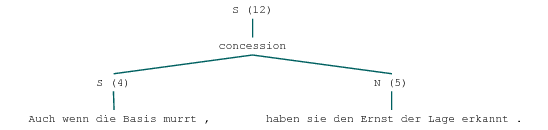

In [19]:
dt(cdict, edict, ordered_edus, start_node='12') # OK

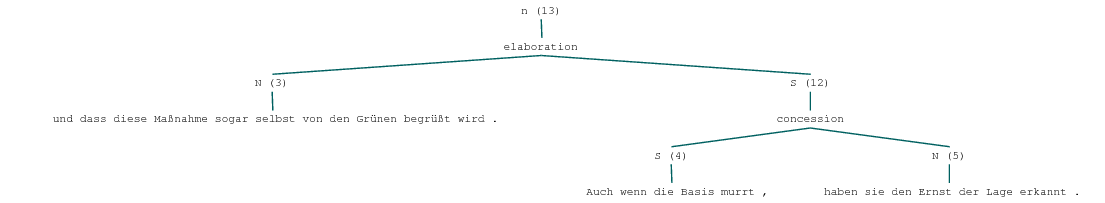

In [20]:
dt(cdict, edict, ordered_edus, start_node='13') # OK

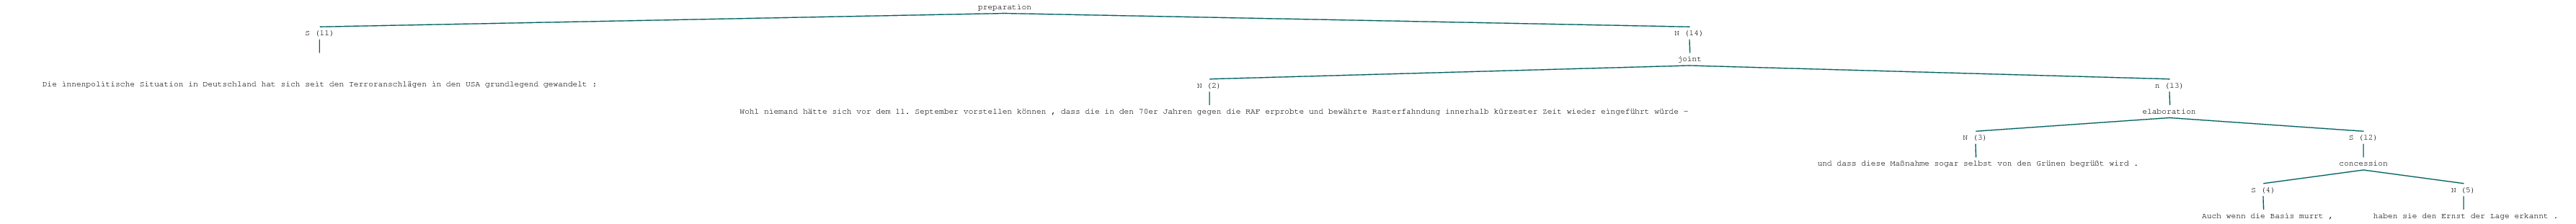

In [21]:
dt(cdict, edict, ordered_edus, start_node='14') # OK

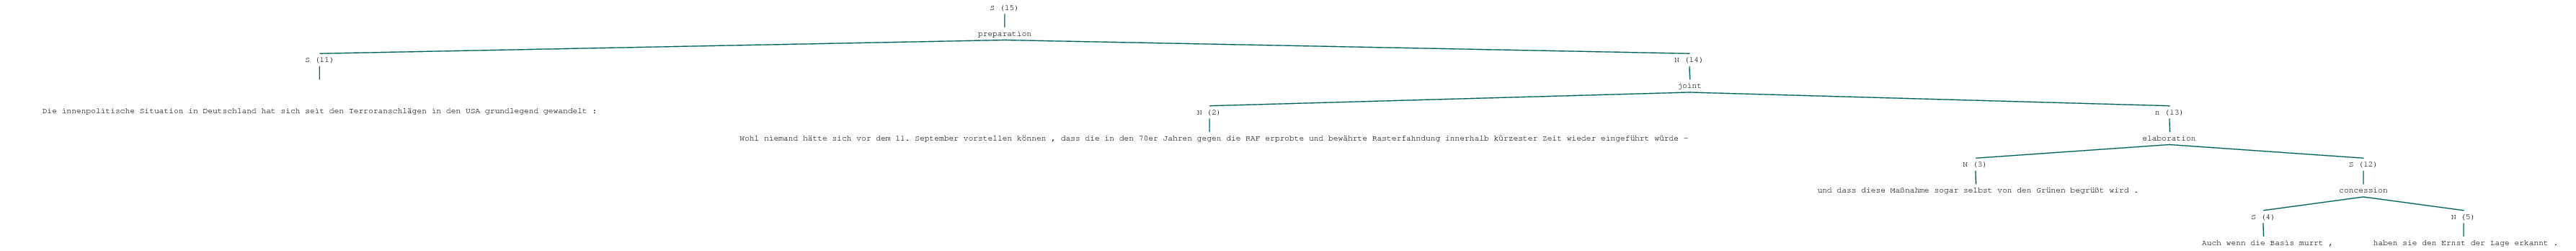

In [22]:
dt(cdict, edict, ordered_edus, start_node='15') # OK

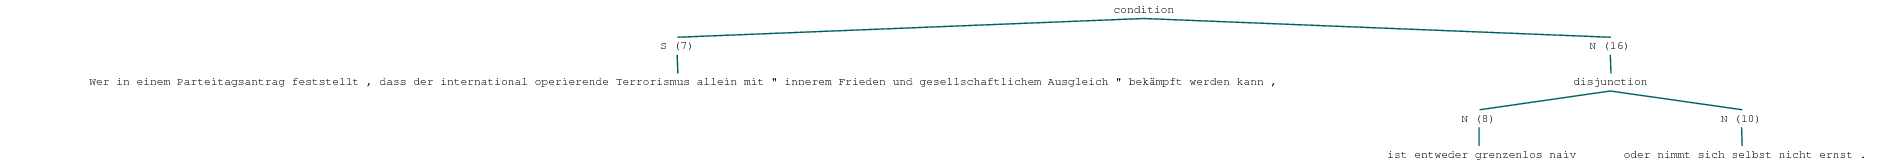

In [23]:
dt(cdict, edict, ordered_edus, start_node='16') # OK

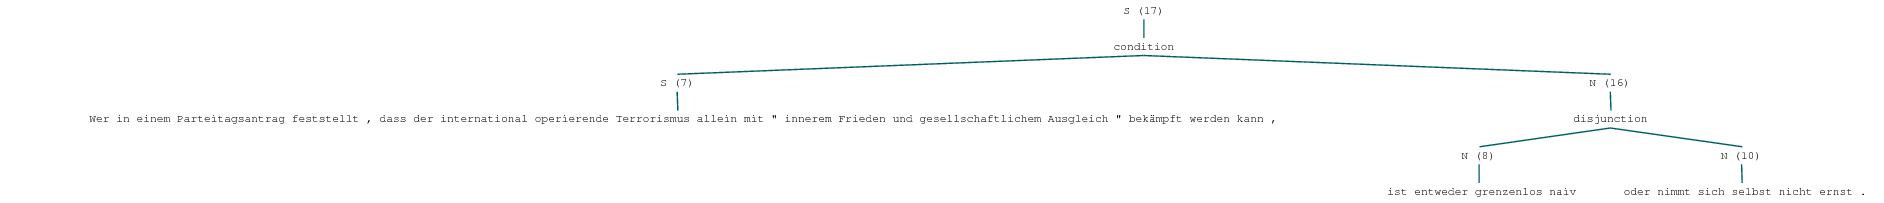

In [24]:
dt(cdict, edict, ordered_edus, start_node='17') # OK

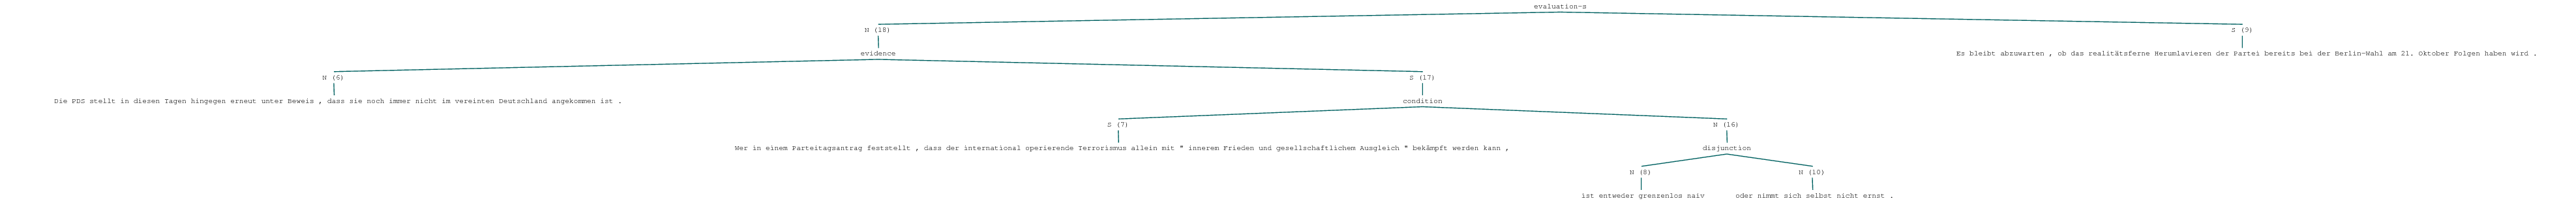

In [25]:
dt(cdict, edict, ordered_edus, start_node='18') # OK

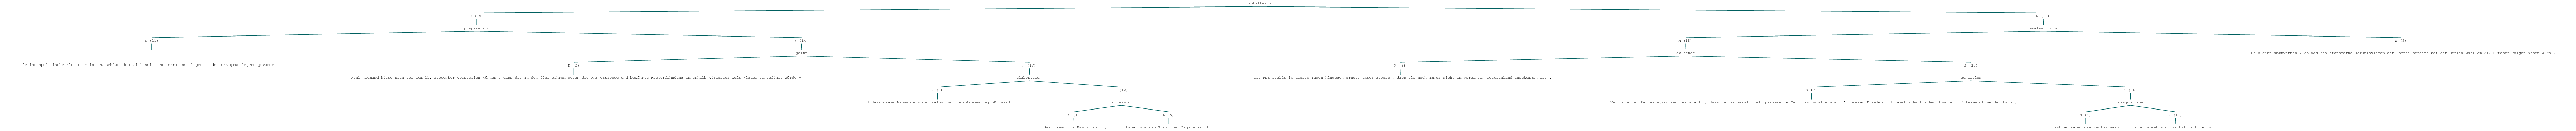

In [26]:
dt(cdict, edict, ordered_edus, start_node='19') # OK

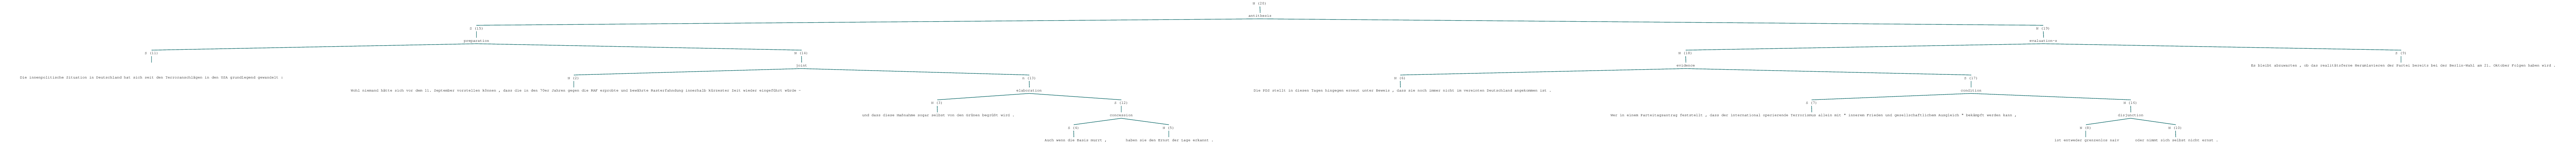

In [27]:
dt(cdict, edict, ordered_edus, start_node='20') # not implemented

# TODOs

## implement word-wrap
## only show node number in debug mode (otherwise: 'N' or 'S')